In [2]:
from torchvision import datasets, transforms
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd

torch.manual_seed(42)

c:\Users\DELL\Anaconda3\envs\usda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load the data
class FashionDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
      # Load the csv file
      self.data = pd.read_csv('./data/fashion-mnist_train.csv')
      self.transform = transform
    def __len__(self):
      return len(self.data)
    def __getitem__(self, idx):
      image = self.data.iloc[idx, 1:].values.reshape(28, 28).astype(np.uint8)
      label = self.data.iloc[idx, 0]
      if self.transform:
          image = self.transform(image)
      return image, label

transform = transforms.ToTensor()
train = FashionDataset(transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = 256, shuffle = True)

In [12]:
# Summarize and overview the data 
print('Number of images in the dataset: ', len(train))
print('Shape of the image: ', train[0][0].shape)
print('Label of the image: ', train[0][1])
print('Number of Labels: ', len(set(train.data.iloc[:, 0])))
print('Labels: ', set(train.data.iloc[:, 0]))

Number of images in the dataset:  60000
Shape of the image:  torch.Size([1, 28, 28])
Label of the image:  2
Number of Labels:  10
Labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


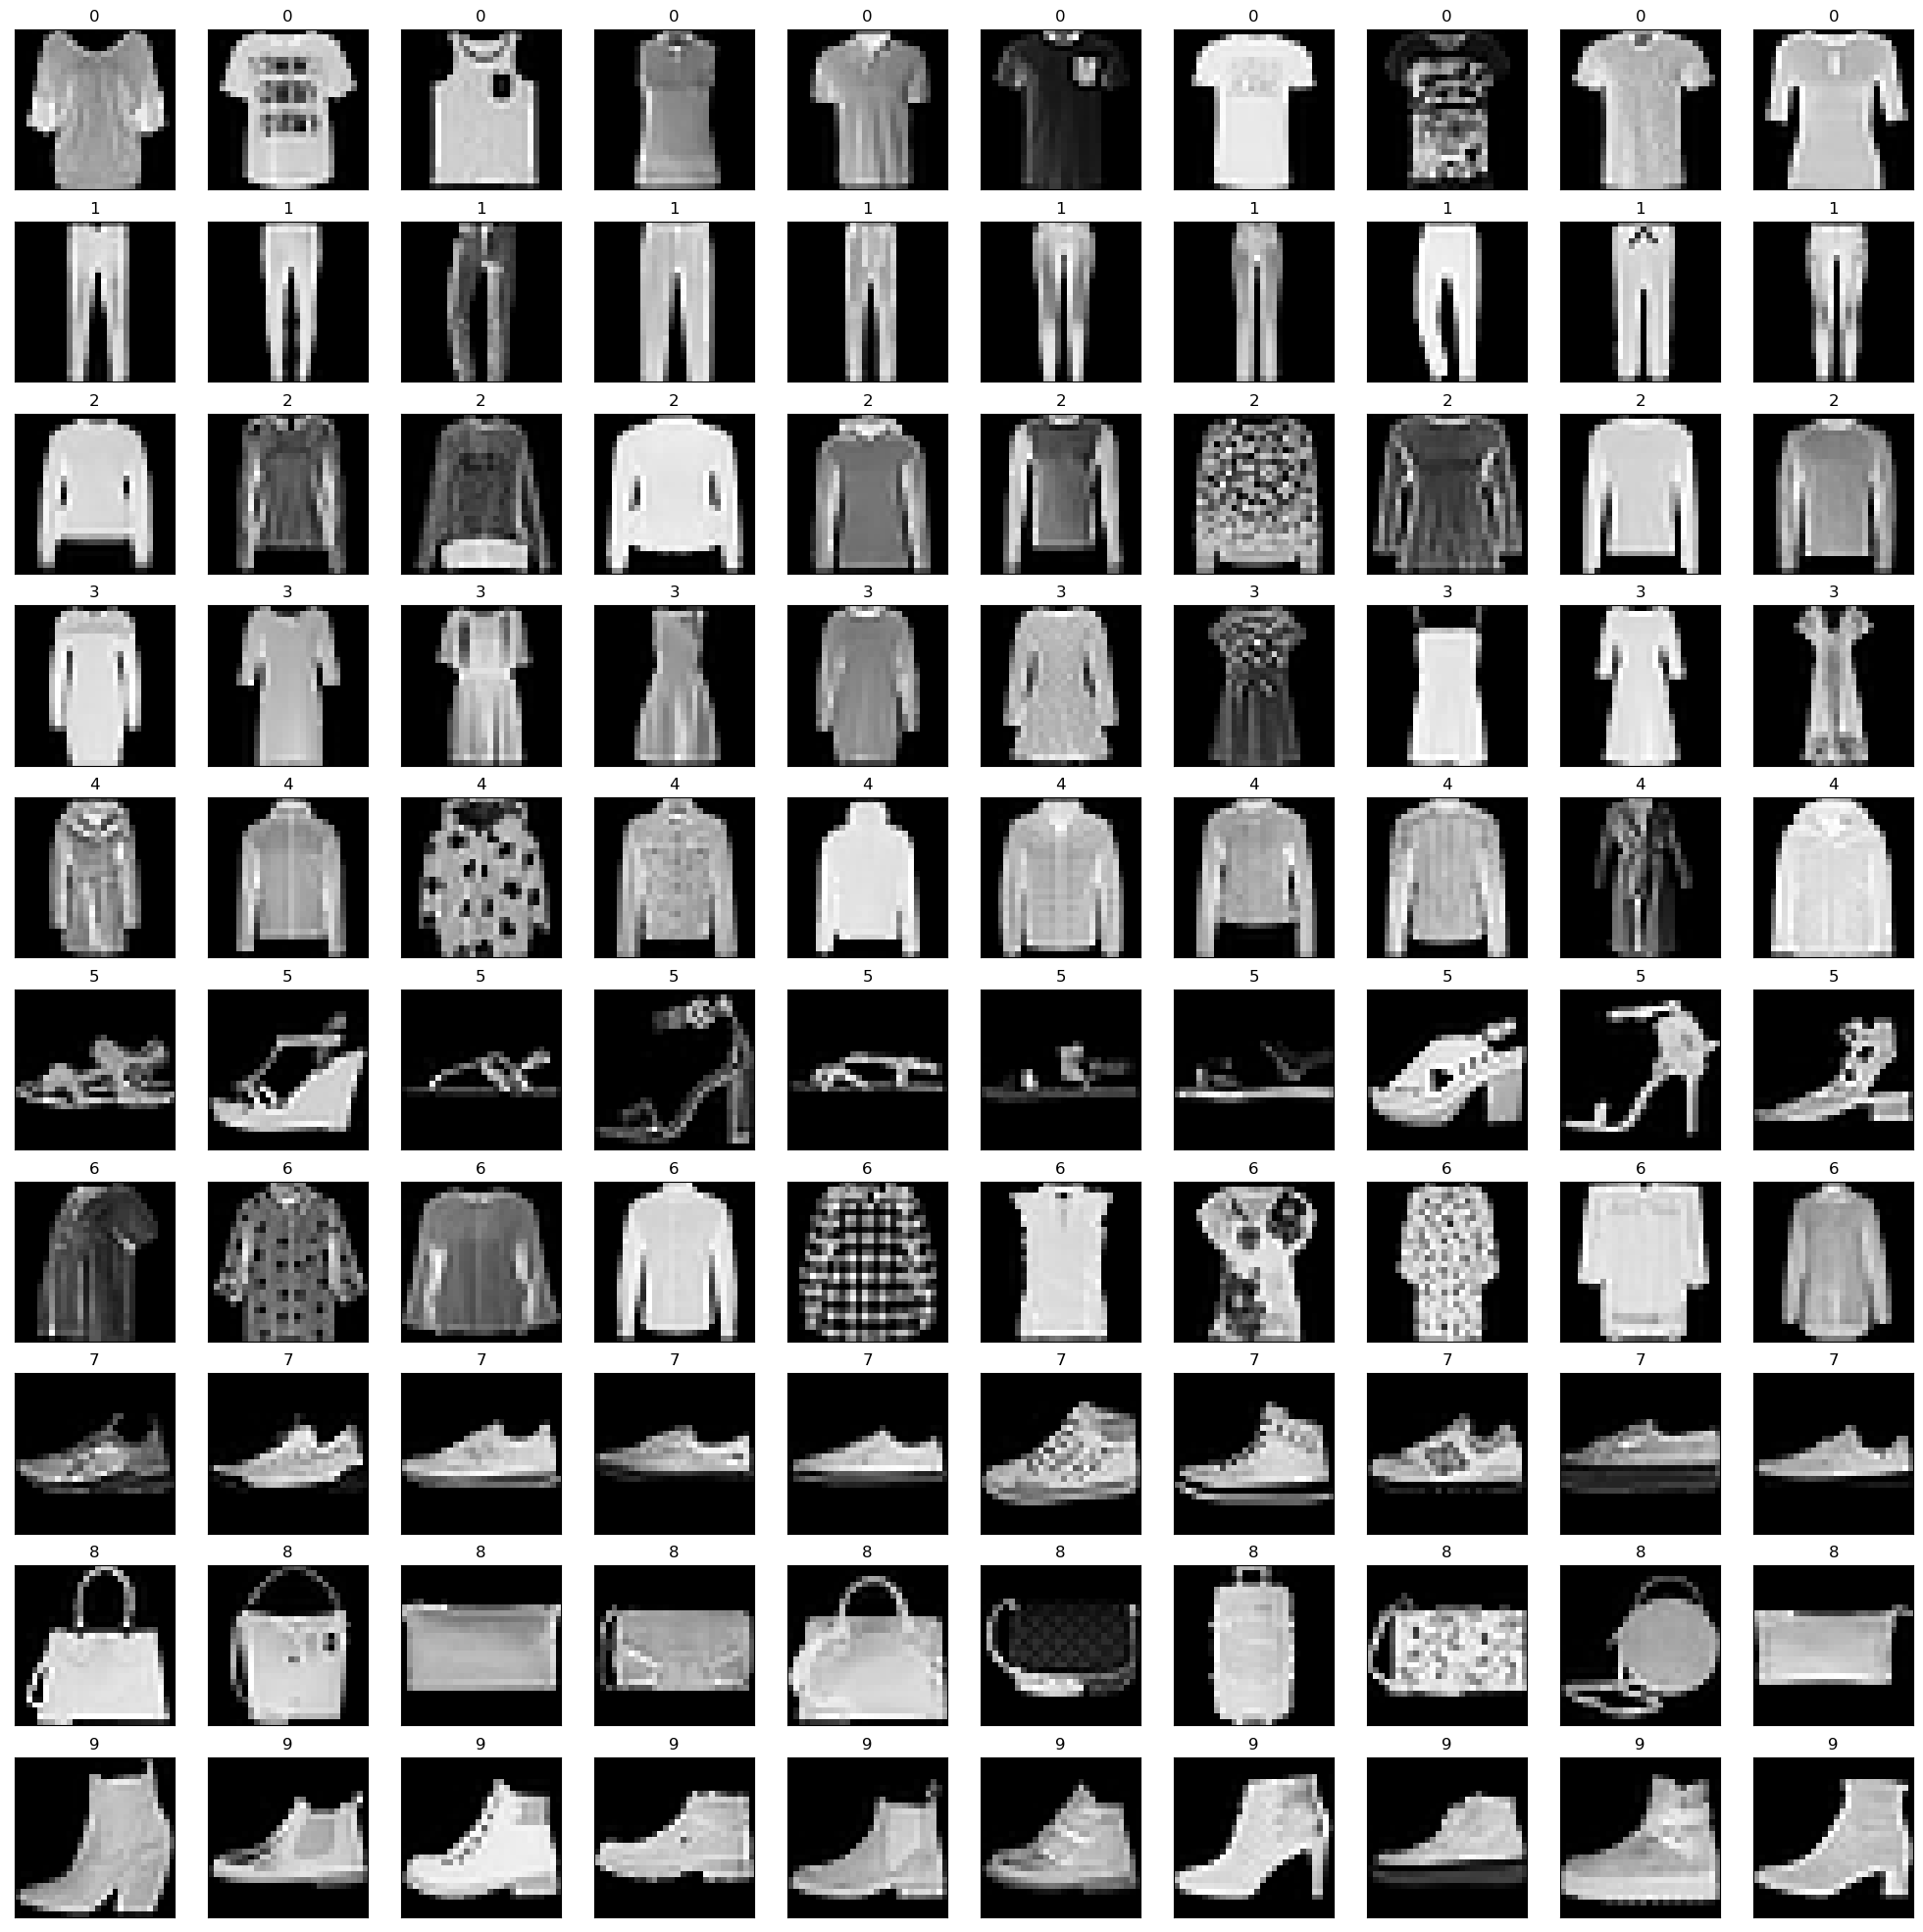

In [25]:
def visualize_data(train_loader):
    """"
        Visualize the data
        This function takes in a train_loader and plots 10 images from each class
    """
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(25,25))
    for i in range(10):
        for j in range(10):
            # Select one image with the label i
            img = np.reshape(images[labels == i][j].numpy(), (28, 28))
            # Plot the image
            axes[i][j].imshow(img, cmap='gray')
            axes[i][j].set_title(i)
            axes[i][j].get_xaxis().set_visible(False)
            axes[i][j].get_yaxis().set_visible(False)

visualize_data(train_loader)

In [38]:
# construct 
class generator(nn.Module):
  def __init__(self):
    super().__init__()
    #100->32->64->128->784
    # The following layers are fully connected layers
    # The model is MLP
    self.dense0 = nn.Linear(100, 32) #receive a vector of 100 numbers random
    self.dense1 = nn.Linear(32, 64) # dense is a fully connected layer
    self.dense2 = nn.Linear(64, 128)
    self.dense3 = nn.Linear(128, 784)
    self.dropout = nn.Dropout(0.3)  # dropout for regularization

  def forward(self, X):
    # 0.2 is the factor of leaky_relu
    X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))# leaky_relu (value * factor)
    X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
    X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
    X = torch.tanh(self.dense3(X)) # literature, the last layer is tanh 
    X = X.view(X.shape[0], 28, 28) # convert to image (matrix)
    return X

class discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    #784->128->64->32->1
    # The following layers are fully connected layers
    self.dense0 = nn.Linear(784, 128)
    self.dense1 = nn.Linear(128, 64)
    self.dense2 = nn.Linear(64, 32)
    self.dense3 = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.3)

  def forward(self, X):
    X = X.view(X.shape[0], 28*28)
    X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
    X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
    X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
    X = self.dense3(X)
    return X

G = generator()
D = discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = 0.002)
D_optimizer = optim.Adam(D.parameters(), lr = 0.002)

criterion = nn.BCEWithLogitsLoss() # combine sigmoid with and BCELoss

In [39]:
# Make sure the model is trained on GPU
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [40]:
G.to(device)
D.to(device)

discriminator(
  (dense0): Linear(in_features=784, out_features=128, bias=True)
  (dense1): Linear(in_features=128, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [41]:
D_losses = []
G_losses = []

for epoch in range(100):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (images_real, _) in enumerate(train_loader):
        batch_size = images_real.size(0)
        images_real = images_real * 2 - 1
        images_real = images_real.to(device)

        # Train The Generator
        G_optimizer.zero_grad()
        random = np.random.uniform(low=-1., high=1., size=(batch_size, 100))
        random = torch.from_numpy(random).float().to(device)
        images_false = G.forward(random)
        output_false = D.forward(images_false)
        labels_false = torch.ones(batch_size).to(device)
        G_loss = criterion(output_false.view(*labels_false.shape), labels_false)
        G_loss.backward()
        G_optimizer.step()

        # Train The Discriminator
        D_optimizer.zero_grad()
        outputs_real = D.forward(images_real)
        labels_real = (torch.ones(batch_size) * 0.9).to(device)
        D_loss_real = criterion(outputs_real.view(*labels_real.shape), labels_real)

        random = np.random.uniform(-1., 1., (batch_size, 100))
        random = torch.from_numpy(random).float().to(device)
        images_false = G.forward(random)
        outputs_false = D.forward(images_false)
        labels_false = torch.zeros(batch_size).to(device)
        D_loss_false = criterion(outputs_false.view(*labels_false.shape), labels_false)

        D_loss = D_loss_real + D_loss_false
        D_loss.backward()
        D_optimizer.step()

        D_running_loss += D_loss.item()
        G_running_loss += G_loss.item()
  
  
    # print the loss after each epoch
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    print('EPOCH {:03d} finalized: discriminator loss {:03.6f} - gererator loss {:03.6f}      '.format(epoch + 1, D_running_loss, G_running_loss))

    # save the loss for each epoch
    D_losses.append(D_running_loss)
    G_losses.append(G_running_loss)
    
    ###################################################################################
    # generate images for the test set
    # Uncomment the following lines to see the generated images

    # fig, ax = plt.subplots(1, 5, figsize=(10,5))
    # for i in range(5):
    #   ax[i].imshow(images_false.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
    #   ax[i].xaxis.set_visible(False)  # hide the x and y ticks
    #   ax[i].yaxis.set_visible(False)
    # plt.show()
    ####################################################################################

# generate images for the test set
random = np.random.uniform(-1., 1., (20, 100))

# convert to tensor for the generator
random = torch.from_numpy(random).float().to(device)

# generate images from the random vector using the generator
G.eval()
output  = G.forward(random)
output = outputs_false.cpu().detach().numpy()

EPOCH 001 finalized: discriminator loss 0.874456 - gererator loss 3.247336      
EPOCH 002 finalized: discriminator loss 0.784318 - gererator loss 4.274339      
EPOCH 003 finalized: discriminator loss 0.624040 - gererator loss 4.126548      
EPOCH 004 finalized: discriminator loss 0.620304 - gererator loss 4.043125      
EPOCH 005 finalized: discriminator loss 0.844681 - gererator loss 3.202266      
EPOCH 006 finalized: discriminator loss 0.907263 - gererator loss 2.890665      
EPOCH 007 finalized: discriminator loss 0.887227 - gererator loss 3.122180      
EPOCH 008 finalized: discriminator loss 0.877012 - gererator loss 3.002432      
EPOCH 009 finalized: discriminator loss 0.883411 - gererator loss 3.253510      
EPOCH 010 finalized: discriminator loss 0.836307 - gererator loss 3.217645      
EPOCH 011 finalized: discriminator loss 0.929608 - gererator loss 2.802503      
EPOCH 012 finalized: discriminator loss 0.943679 - gererator loss 2.620310      
EPOCH 013 finalized: discrim

Text(0, 0.5, 'Loss')

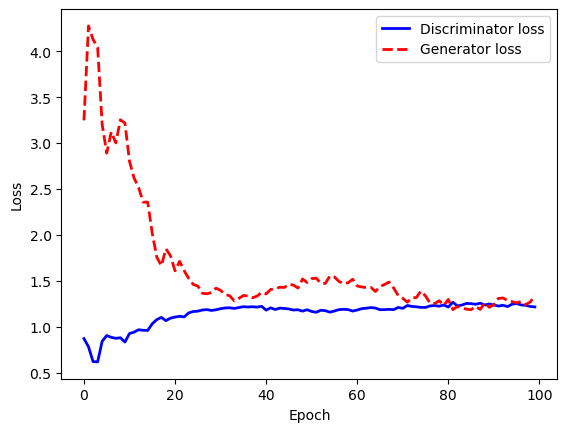

In [50]:
#######################################################################
# plot the discriminator and generator loss
plt.plot(D_losses, label='Discriminator loss', color='blue', linewidth=2)
plt.plot(G_losses, label='Generator loss', color='red', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')